In [1]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
import numpy as np
import copy
from utils.loss import calculate_RMS
import matplotlib.pyplot as plt
import gets.get_intermediate_transfer_matrix as get_W
from gets.get_E import get_E

# Initialize
wls = np.linspace(500, 1000, 500)
inc_ang = 60.


def plot_film(f: FilmSimple):
    f.add_spec_param(inc_ang, wls)
    spectrum_before_sub = f.get_spec()
    spectrum_before_sub.calculate() # compile cuda kernel func
    # plot_spectrum(spectrum_before_sub)

np.random.seed(3)
f = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(200) * 30)
plot_film(f)

c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [95]:
f_sub1 = copy.deepcopy(f)



def equal_optical_thickness(f: FilmSimple, d_min):
    d = f.get_d()
    i = 1
    count = 0
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]
            d[i - 1] += optical_ratio * d[i] + d[i + 1]
            d = np.delete(d, [i, i + 1])
            i -= 1
            count += 1
        i += 1
    f.update_d(d)
    return count

def search_ot_substitution(f: FilmSimple, f_origin: FilmSimple, d_min):
    d = f.get_d()
    i = 1
    count = 0
    ratios = []
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]
            m = calculate_RMS(f, f_origin)

            for r in np.linspace(0, d_min * 10, 10):
                d_tmp = d.copy()
                # substitute
                d_tmp[i - 1] += r * optical_ratio * d[i] + d[i + 1]
                d_tmp = np.delete(d_tmp, [i, i + 1])

                f.update_d(d_tmp)
                m = calculate_RMS(f, f_origin)
                if r == 0. or m < best_m: # first search set as tmp best
                    best_m = m
                    best_d = d_tmp.copy()
                    best_r = r
            d = best_d
            ratios.append(best_r)
            count += 1

            i -= 1
        i += 1
    f.update_d(d)
    return count, ratios

def search_keeplayer_substitution(f: FilmSimple, f_origin: FilmSimple, d_min, search=None):
    search = np.linspace(d_min, d_min * 100, 100) if search is None else search
    d = f.get_d()
    i = 1
    count = 0
    sub_d_s = []
    merit_record = []
    d_record = []
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]

            this_merit_record = []
            this_d_record = []
            for r in search:
                d_iminus1_tmp = d[i]

                d[i] = r
                this_d_record.append(r)

                f.update_d(d)
                m = calculate_RMS(f, f_origin)
                this_merit_record.append(m)
                # print(m)
                if r == search[0] or m < best_m: # first search set as tmp best
                    best_m = m
                    best_d = d.copy()
                    best_r = r
                
                d[i] = d_iminus1_tmp # restore to search for others
            d = best_d
            sub_d_s.append(best_r)
            count += 1
            merit_record.append(this_merit_record)
            d_record.append(this_d_record)        
        i += 1

    f.update_d(d)
    return count, sub_d_s, merit_record, d_record


def optimal_and_thin_film_approx_substitution_onestep(f: FilmSimple, d_min):
    '''
    Assuming the layers adjacent to very thin films are thin enough. Use linerization to get 
    an analytical optimal solution in the first order approximation.

    One step: thickness compensation always adds to the previous layer. When adjaecnt thin layers,
    one of their correction would be neglected
    '''
    # assume single spec
    assert len(f.get_all_spec_list()) == 1, "too many spectrums"
    # load params to the get W function
    d = f.get_d()
    spec = f.get_spec()
    count = 0
    ratios = []
    delete_indices = []
    i = 1
    while i < d.shape[0]: # neglect the last layer
        if f.get_d()[i] < d_min:
            Q1 = get_W.get_W_before_ith_layer(
                spec.WLS,
                f.get_d(),
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i
            )

            Q2 = get_W.get_W_after_ith_layer(
                spec.WLS,
                f.get_d(),
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i
            )
            
            """
            Below is how A is defined. Note that x is to be solved
            A = np.empty((spec.WLS.shape[0] * 2, 2, 2), dtype='complex128')
            for k in range(spec.WLS.shape[0]):
                this_n = spec.n[k, i] # to be substituted, material A
                next_n = spec.n[k, i + 1] # to substitute, material B
                
                this_cos = np.sqrt(1 - (1 / this_n * np.sin(spec.INC_ANG)) ** 2)
                next_cos = np.sqrt(1 - (1 / next_n * np.sin(spec.INC_ANG)) ** 2)
            
                # s-polarized, x is the increment in d[i+1] to solve for
                A[k, :, :] = np.array([[0, -1j * 2 * np.pi / spec.WLS[k] * (next_n**2 * x - this_n**2 * d[i])], 
                            [-1j * 2 * np.pi / spec.WLS[k] * (x * next_cos**2 - d[i] * this_cos**2), 0]])
                # p-polarized
                A[k + spec.WLS.shape[0], :, :] = np.array([[0, -1j * 2 * np.pi / spec.WLS[k] * (x - d[i])], 
                            [-1j * 2 * np.pi / spec.WLS[k] * (x * next_n**2 * next_cos**2 - d[i] * this_n**2 * this_cos**2), 0]])
            """
            E = get_E(
                spec.WLS,
                f.get_d(),
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG
            )
            
            nB = np.repeat(spec.n[:, i + 1], 2, axis=0)
            nA = np.repeat(spec.n[:, i], 2, axis=0)
            wls = np.repeat(spec.WLS, 2, axis=0)
            dA = f.get_d()[i]
            
            A_1 = np.array([[[0, 1], [0, 0]] for k in range(2 * spec.WLS.shape[0])])
            A_2 = np.array([[[0, 0], [1, 0]] for k in range(2 * spec.WLS.shape[0])])
            # solve A_lambda1 and A_lambda2 respectively and acquire the ratio between d_B and d_A
            partialL_A_1 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_1 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            partialL_A_2 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_2 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            a1 = nB**2 * partialL_A_1[:, 0, 1] + nB ** -2 * partialL_A_1[:, 1, 0]
            a2 = nB**2 * partialL_A_2[:, 0, 1] + nB ** -2 * partialL_A_2[:, 1, 0]

            '''
            Then solve 
                lambda1 / lambda2 = (nB^2 dB - nA^2 dA) / (nB^-2 dB - nA^-2 dA)
            So
                dB = (nA^-2 dA (lambda1/lambda2) + nA^2 dA) / (-lambda1 / lambda2 nB^-2 + nB^2)
            '''
            dB = dA * (np.dot(a1, (nA**2 / wls)) - np.dot(a2, 1 /(nA**2 * wls))) / \
                (np.dot(a1, (nB**2 / wls)) - np.dot(a2, 1 /(nB**2 * wls)))

            # save substitution info
            this_ot_ratio = (nB[wls.shape[0]//2] * dB) / (nA[wls.shape[0]//2] * dA)
            count += 1
            ratios.append(this_ot_ratio)
            # update d
            i_to_add = i
            for i_to_del in delete_indices[::-1]:
                if i_to_del != i_to_add:
                    break
                else:
                    i_to_add -= 1
            
            if i == d.shape[0] - 1:
                d[i - 1] += dB
            else:
                d[i - 1] += d[i + 1] + dB
            delete_indices += [i, i + 1]
            i += 1

        i += 1
        # end loop

    
    d = np.delete(d, delete_indices).real
    f.update_d(d)
    return count, ratios


def optimal_and_thin_film_approx_substitution_greedy(f: FilmSimple, d_min):
    '''
    Assuming the layers adjacent to very thin films are thin enough. Use linerization to get 
    an analytical optimal solution in the first order approximation.
    '''
    # assume single spec
    assert len(f.get_all_spec_list()) == 1, "too many spectrums"
    # load params to the get W function
    d = f.get_d()
    spec = f.get_spec()
    count = 0
    ratios = []
    i = 1
    while i < d.shape[0] - 1: # neglect the last layer
        if d[i] < d_min:
            Q1 = get_W.get_W_before_ith_layer(
                spec.WLS,
                d,
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i
            )

            Q2 = get_W.get_W_after_ith_layer(
                spec.WLS,
                d,
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i
            )

            nB = np.repeat(spec.n[:, i + 1], 2, axis=0)
            nA = np.repeat(spec.n[:, i], 2, axis=0)
            wls = np.repeat(spec.WLS, 2, axis=0)
            dA = d[i]
            
            A_1 = np.array([[[0, 1], [0, 0]] for k in range(2 * spec.WLS.shape[0])])
            A_2 = np.array([[[0, 0], [1, 0]] for k in range(2 * spec.WLS.shape[0])])
            # solve A_lambda1 and A_lambda2 respectively and acquire the ratio between d_B and d_A
            # TODO: should have used hermite conjugate. Don't forget to check consistency in the real part!
            partialL_A_1 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_1 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            partialL_A_2 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_2 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            a1 = nB**2 * partialL_A_1[:, 0, 1] + nB ** -2 * partialL_A_1[:, 1, 0]
            a2 = nB**2 * partialL_A_2[:, 0, 1] + nB ** -2 * partialL_A_2[:, 1, 0]

            dB = dA * (np.dot(a1, (nA**2 / wls)) - np.dot(a2, 1 /(nA**2 * wls))) / \
                (np.dot(a1, (nB**2 / wls)) - np.dot(a2, 1 /(nB**2 * wls)))
            
            # save substitution info
            this_ot_ratio = (nB[wls.shape[0]//2] * dB) / (nA[wls.shape[0]//2] * dA)
            count += 1
            ratios.append(this_ot_ratio)

            # update d
            d[i + 1] += d[i - 1] + dB
            d = np.delete(d, [i, i - 1])
            d = d.real
            f.update_d(d)

            i -= 1
        i += 1
        # end loop

    if d[-1] < d_min:
        d = np.delete(d, -1)
    
    f.update_d(d)
    return count, ratios


def optimal_and_thin_film_approx_substitution_onestep_new(f: FilmSimple, d_min):
    '''
    Assuming the layers adjacent to very thin films are thin enough. Use linerization to get 
    an analytical optimal solution in the first order approximation.

    One step: thickness compensation always adds to the previous layer. When adjaecnt thin layers,
    one of their correction would be neglected
    '''
    # assume single spec
    assert len(f.get_all_spec_list()) == 1, "too many spectrums"
    # load params to the get W function
    d = f.get_d()
    spec = f.get_spec()
    count = 0
    ratios = []
    delete_indices = []
    i = 1
    while i < d.shape[0]: # neglect the last layer
        if f.get_d()[i] < d_min:
            Q1 = get_W.get_W_before_ith_layer(
                spec.WLS,
                f.get_d(),
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i + 1
            )

            Q2 = get_W.get_W_after_ith_layer(
                spec.WLS,
                f.get_d(),
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i + 1
            )
            
            """
            Below is how A is defined. Note that x is to be solved
            A = np.empty((spec.WLS.shape[0] * 2, 2, 2), dtype='complex128')
            for k in range(spec.WLS.shape[0]):
                this_n = spec.n[k, i] # to be substituted, material A
                next_n = spec.n[k, i + 1] # to substitute, material B
                
                this_cos = np.sqrt(1 - (1 / this_n * np.sin(spec.INC_ANG)) ** 2)
                next_cos = np.sqrt(1 - (1 / next_n * np.sin(spec.INC_ANG)) ** 2)
            
                # s-polarized, x is the increment in d[i+1] to solve for
                A[k, :, :] = np.array([[0, -1j * 2 * np.pi / spec.WLS[k] * (next_n**2 * x - this_n**2 * d[i])], 
                            [-1j * 2 * np.pi / spec.WLS[k] * (x * next_cos**2 - d[i] * this_cos**2), 0]])
                # p-polarized
                A[k + spec.WLS.shape[0], :, :] = np.array([[0, -1j * 2 * np.pi / spec.WLS[k] * (x - d[i])], 
                            [-1j * 2 * np.pi / spec.WLS[k] * (x * next_n**2 * next_cos**2 - d[i] * this_n**2 * this_cos**2), 0]])
            """
            E = get_E(
                spec.WLS,
                f.get_d(),
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG
            )
            
            nB = np.repeat(spec.n[:, i + 1], 2, axis=0)
            nA = np.repeat(spec.n[:, i], 2, axis=0)
            wls = np.repeat(spec.WLS, 2, axis=0)
            dA = f.get_d()[i]
            
            A_1 = np.array([[[0, 1], [0, 0]] for k in range(2 * spec.WLS.shape[0])])
            A_2 = np.array([[[0, 0], [1, 0]] for k in range(2 * spec.WLS.shape[0])])
            # solve A_lambda1 and A_lambda2 respectively and acquire the ratio between d_B and d_A
            partialL_A_1 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_1 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            partialL_A_2 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_2 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            a1 = nB**2 * partialL_A_1[:, 0, 1] + nB ** -2 * partialL_A_1[:, 1, 0]
            a2 = nB**2 * partialL_A_2[:, 0, 1] + nB ** -2 * partialL_A_2[:, 1, 0]

            '''
            Then solve 
                lambda1 / lambda2 = (nB^2 dB - nA^2 dA) / (nB^-2 dB - nA^-2 dA)
            So
                dB = (nA^-2 dA (lambda1/lambda2) + nA^2 dA) / (-lambda1 / lambda2 nB^-2 + nB^2)
            '''
            dB = dA * (np.dot(a1, (nA**2 / wls)) - np.dot(a2, 1 /(nA**2 * wls))) / \
                (np.dot(a1, (nB**2 / wls)) - np.dot(a2, 1 /(nB**2 * wls)))

            # save substitution info
            this_ot_ratio = (nB[wls.shape[0]//2] * dB) / (nA[wls.shape[0]//2] * dA)
            count += 1
            ratios.append(this_ot_ratio)
            # update d
            i_to_add = i
            for i_to_del in delete_indices[::-1]:
                if i_to_del != i_to_add:
                    break
                else:
                    i_to_add -= 1
            
            if i == d.shape[0] - 1:
                d[i - 1] += dB
            else:
                d[i - 1] += d[i + 1] + dB
            delete_indices += [i, i + 1]
            i += 1

        i += 1
        # end loop

    
    d = np.delete(d, delete_indices).real
    f.update_d(d)
    return count, ratios


def optimal_and_thin_film_approx_substitution_greedy_new(f: FilmSimple, d_min):
    '''
    Assuming the layers adjacent to very thin films are thin enough. Use linerization to get 
    an analytical optimal solution in the first order approximation.
    '''
    # assume single spec
    assert len(f.get_all_spec_list()) == 1, "too many spectrums"
    # load params to the get W function
    d = f.get_d()
    spec = f.get_spec()
    count = 0
    ratios = []
    i = 1
    while i < d.shape[0] - 1: # neglect the last layer
        if d[i] < d_min:
            Q1 = get_W.get_W_before_ith_layer(
                spec.WLS,
                d,
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i + 1
            )

            Q2 = get_W.get_W_after_ith_layer(
                spec.WLS,
                d,
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i + 1
            )

            nB = np.repeat(spec.n[:, i + 1], 2, axis=0)
            nA = np.repeat(spec.n[:, i], 2, axis=0)
            wls = np.repeat(spec.WLS, 2, axis=0)
            dA = d[i]
            
            A_1 = np.array([[[0, 1], [0, 0]] for k in range(2 * spec.WLS.shape[0])])
            A_2 = np.array([[[0, 0], [1, 0]] for k in range(2 * spec.WLS.shape[0])])
            # solve A_lambda1 and A_lambda2 respectively and acquire the ratio between d_B and d_A
            # TODO: should have used hermite conjugate. Don't forget to check consistency in the real part!
            partialL_A_1 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_1 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            partialL_A_2 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_2 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            a1 = nB**2 * partialL_A_1[:, 0, 1] + nB ** -2 * partialL_A_1[:, 1, 0]
            a2 = nB**2 * partialL_A_2[:, 0, 1] + nB ** -2 * partialL_A_2[:, 1, 0]

            dB = dA * (np.dot(a1, (nA**2 / wls)) - np.dot(a2, 1 /(nA**2 * wls))) / \
                (np.dot(a1, (nB**2 / wls)) - np.dot(a2, 1 /(nB**2 * wls)))
            
            # save substitution info
            this_ot_ratio = (nB[wls.shape[0]//2] * dB) / (nA[wls.shape[0]//2] * dA)
            count += 1
            ratios.append(this_ot_ratio)

            # update d
            d[i + 1] += d[i - 1] + dB
            d = np.delete(d, [i, i - 1])
            d = d.real
            f.update_d(d)

            i -= 1
        i += 1
        # end loop

    if d[-1] < d_min:
        d = np.delete(d, -1)
    
    f.update_d(d)
    return count, ratios


In [3]:
d_mins_1 = np.linspace(0, 10, 100)
losses_1 = []
for d_min in d_mins_1:
    count = equal_optical_thickness(f_sub1, d_min)
    losses_1.append(calculate_RMS(f, f_sub1))
    # print(merits[-1], "min d:", d_min, 'and', count, "layers deleted")


C:\Users\rfeng6\AppData\Local\Temp\ipykernel_17752\1819901123.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i - 1] += optical_ratio * d[i] + d[i + 1]


(0, [])
(0, [])
(0, [])
(0, [])
(0, [])
(0, [])
(0, [])
(0, [])


C:\Users\rfeng6\AppData\Local\Temp\ipykernel_17752\4208512541.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  d_tmp[i - 1] += r * optical_ratio * d[i] + d[i + 1]


(1, [0.0])
(2, [0.0, 1.01010101010101])
(2, [0.0, 1.1223344556677892])
(2, [0.0, 0.0])
(2, [0.0, 0.0])
(2, [0.0, 0.0])
(3, [0.0, 0.0, 0.0])
(4, [0.0, 0.0, 1.6835016835016836, 0.0])
(5, [0.0, 0.0, 1.7957351290684624, 0.0, 0.0])
(5, [0.0, 0.0, 1.907968574635241, 0.0, 0.0])
(6, [0.0, 0.0, 2.02020202020202, 0.0, 2.02020202020202, 0.0])
(8, [0.0, 0.0, 2.1324354657687987, 0.0, 2.1324354657687987, 2.1324354657687987, 0.0, 0.0])
(10, [0.0, 0.0, 2.2446689113355784, 0.0, 2.2446689113355784, 0.0, 2.2446689113355784, 4.489337822671157, 0.0, 0.0])
(10, [0.0, 0.0, 2.356902356902357, 0.0, 2.356902356902357, 0.0, 0.0, 7.070707070707071, 0.0, 0.0])
(12, [0.0, 0.0, 2.4691358024691357, 0.0, 2.4691358024691357, 0.0, 2.4691358024691357, 0.0, 4.938271604938271, 0.0, 0.0, 0.0])
(12, [0.0, 0.0, 2.5813692480359145, 0.0, 0.0, 0.0, 5.162738496071829, 0.0, 5.162738496071829, 0.0, 0.0, 0.0])
(12, [0.0, 0.0, 0.0, 0.0, 2.6936026936026938, 0.0, 5.3872053872053876, 0.0, 5.3872053872053876, 0.0, 0.0, 0.0])
(13, [0.0, 0

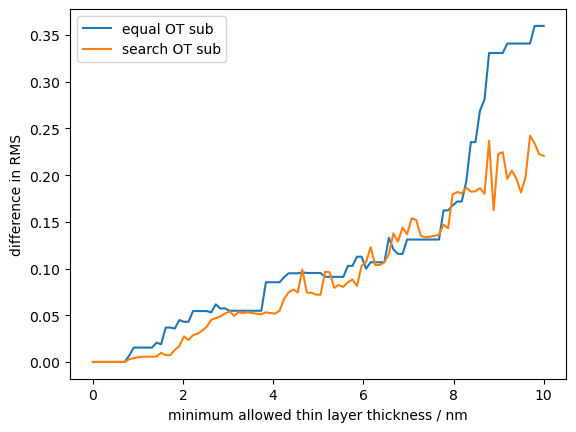

In [32]:

d_mins_2 = d_mins_1.copy()
losses_2= []
# takes about 10 min to run
for d_min in d_mins_2:
    f_sub2 = copy.deepcopy(f)
    count = search_ot_substitution(f_sub2, f, d_min)
    print(count)
    losses_2.append(calculate_RMS(f, f_sub2))

fig, ax = plt.subplots(1, 1)
ax.plot(d_mins_1, losses_1, label='equal OT sub')
ax.plot(d_mins_2, losses_2, label='search OT sub')

ax.set_xlabel('minimum allowed thin layer thickness / nm')
ax.set_ylabel('difference in RMS')
ax.legend()

In [33]:
d_mins_3 = d_mins_1.copy()
losses_3 = []
m_records = []
d_records = []

# takes about 60 mins to run
for d_min in d_mins_3:
    f_sub3 = copy.deepcopy(f)
    count, ratios, m_records_this_dmin, d_records_this_dmin = search_keeplayer_substitution(f_sub3, f, d_min)
    m_records.append(m_records_this_dmin)
    d_records.append(d_records_this_dmin)
    # print(count)
    losses_3.append(calculate_RMS(f, f_sub3))



KeyboardInterrupt: 

In [96]:
# optim dE^2
d_mins_4 = d_mins_1.copy()
losses_4_new = []
ratios_4 = []
# takes~3min
for d_min in d_mins_4:
    f_sub4 = copy.deepcopy(f)
    count, ratio = optimal_and_thin_film_approx_substitution_onestep_new(f_sub4, d_min)
    ratios_4.append(ratio)
    losses_4_new.append(calculate_RMS(f, f_sub4))

# optim dE^2
d_mins_5 = d_mins_1.copy()
losses_5_new = []
ratios_5 = []
# takes~3min
for d_min in d_mins_5:
    f_sub5 = copy.deepcopy(f)
    count, ratio = optimal_and_thin_film_approx_substitution_greedy_new(f_sub5, d_min)
    ratios_5.append(ratio)
    losses_5_new.append(calculate_RMS(f, f_sub5))


C:\Users\rfeng6\AppData\Local\Temp\ipykernel_17752\2633926446.py:386: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i - 1] += d[i + 1] + dB
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_17752\2633926446.py:457: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i + 1] += d[i - 1] + dB


In [93]:
# optim dE^2
d_mins_4 = d_mins_1.copy()
losses_4 = []
ratios_4 = []
# takes~3min
for d_min in d_mins_4:
    f_sub4 = copy.deepcopy(f)
    count, ratio = optimal_and_thin_film_approx_substitution_onestep(f_sub4, d_min)
    ratios_4.append(ratio)
    losses_4.append(calculate_RMS(f, f_sub4))

# optim dE^2
d_mins_5 = d_mins_1.copy()
losses_5 = []
ratios_5 = []
# takes~3min
for d_min in d_mins_5:
    f_sub5 = copy.deepcopy(f)
    count, ratio = optimal_and_thin_film_approx_substitution_greedy(f_sub5, d_min)
    ratios_5.append(ratio)
    losses_5.append(calculate_RMS(f, f_sub5))

C:\Users\rfeng6\AppData\Local\Temp\ipykernel_17752\3152769647.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i - 1] += d[i + 1] + dB
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_17752\3152769647.py:268: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i + 1] += d[i - 1] + dB


In [83]:
ratios_4

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(0.569419383601771+0j)],
 [(0.5801008381322819+0j), (0.5751614507018641+0j)],
 [(0.5801008381322819+0j), (0.5751614507018641+0j)],
 [(0.5801008381322819+0j), (0.5751614507018641+0j)],
 [(0.5801008381322819+0j), (0.5751614507018641+0j)],
 [(0.5801008381322819+0j), (0.5751614507018641+0j)],
 [(0.5801008381322819+0j), (0.5751614507018641+0j), (0.5697773187557341+0j)],
 [(0.5801008381322819+0j),
  (0.5751614507018641+0j),
  (1.7750162076536493+0j),
  (0.5705744147347491+0j)],
 [(0.5923143452246955+0j),
  (0.5664209286551016+0j),
  (0.5735170435666628+0j),
  (1.781705509008307+0j),
  (0.569555336824478+0j)],
 [(0.5923143452246955+0j),
  (0.5664209286551016+0j),
  (0.5735170435666628+0j),
  (1.781705509008307+0j),
  (0.569555336824478+0j)],
 [(0.5923143452246955+0j),
  (0.5664209286551016+0j),
  (0.5735170435666628+0j),
  (1.781705509008307+0j),
  (1.744286782977735+0j),
  (0.5693729405153843+0j)],
 [(0.5923143452246955+0j),
  (0.5664209286551016+0j)

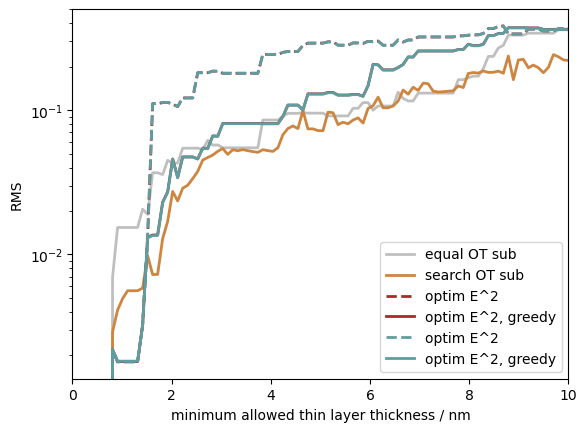

In [97]:
# Note that losses are calculated at all wls, though some methods only involves evaluating n at some characteristic wl
fig, ax = plt.subplots(1, 1)
ax.plot(d_mins_1, losses_1, label='equal OT sub', c='grey', alpha=0.5, linewidth=2, zorder=-1)
ax.plot(d_mins_2, losses_2, label='search OT sub', c='peru', linewidth=2)
# ax.plot(d_mins_3, losses_3, label='search keepLayer sub')
ax.plot(d_mins_4, losses_4[:d_mins_4.shape[0]], label='optim E^2', c='brown', ls='--', linewidth=2)
ax.plot(d_mins_5, losses_5, label='optim E^2, greedy', c='brown', linewidth=2)

ax.plot(d_mins_4, losses_4_new, label='optim E^2', c='cadetblue', ls='--', linewidth=2)
ax.plot(d_mins_5, losses_5_new, label='optim E^2, greedy', c='cadetblue', linewidth=2)

ax.set_xlim(0, 10)
ax.set_xlabel('minimum allowed thin layer thickness / nm')
ax.set_yscale('log')
ax.set_ylabel('RMS')
ax.legend()

TypeError: Invalid shape (10,) for image data

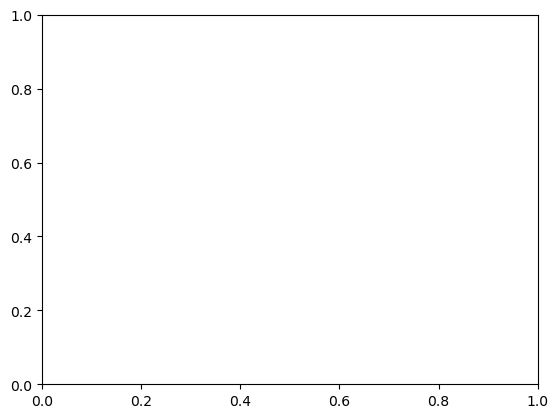

In [ ]:
subed_layer = 0 # layer
d_min_idx = 30 # should > 0

least_d_min_idx = 0
while True:
    try:
        ds = np.array([d_records[i][subed_layer] for i in range(least_d_min_idx, len(d_mins_4))])
        ms = np.array([m_records[i][subed_layer] for i in range(least_d_min_idx, len(d_mins_4))])
    except:
        least_d_min_idx += 1
    else:
        break


fig, ax = plt.subplots(1, 1)
s = ax.imshow(ms, aspect='auto')
ax.invert_yaxis()
ax.set_xlim(0.5, None)
ax.set_xlabel('INDEX of substituted d')
ax.set_ylabel('INDEX of min allowed d')
cbar = fig.colorbar(s)

print(f.get_d())